# CAMELS Rockstar Halos: GNN Classification Project

This notebook will guide you through:
- Downloading Rockstar halo catalogs from the CAMELS simulations
- Preparing the data into a graph format
- Visualizing the halo connections
- Building a Graph Neural Network (GNN) model
- Training and evaluating the model

---

## Step 1: Install and Import Libraries


In [12]:
# Install required packages
!pip install torch torch-geometric networkx matplotlib torchsummary

# Import libraries
import os
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Step 2: Download CAMELS Rockstar Data

We will download a subset of the Rockstar catalogs.

Source: [CAMELS Data Portal](https://users.flatironinstitute.org/~camels/)

For this example, we'll use one of the available catalogs.

In [2]:
# Download Rockstar halo catalog
!wget https://users.flatironinstitute.org/~camels/Rockstar/CAMELS-SAM/LH/LH_832/Rockstar/out_66.list

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Create the data directory if it doesn't exist
data_dir = "/content/drive/MyDrive/data"  # Specify the desired path in your Google Drive
os.makedirs(data_dir, exist_ok=True)

# Move the downloaded file to the Google Drive directory
!mv /content/out_66.list /content/drive/MyDrive/data/

# Read the file from Google Drive
file_path = "/content/drive/MyDrive/data/out_66.list"
try:
  with open(file_path, 'r') as file:
      # Process the file content here
      # For example, read lines, analyze data, etc.
      lines = file.readlines()
      # Print the first few lines to verify
      print("First 5 lines of the file:")
      for i in range(5):
          print(lines[i].strip())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

Mounted at /content/drive
mv: cannot stat '/content/out_66.list': No such file or directory
First 5 lines of the file:
#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius
#a = 0.655148
#Om = 0.491800; Ol = 0.508200; h = 0.671100
#FOF linking length: 0.280000
#Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000


In [3]:
with open(file_path, 'r') as file:
      lines = file.readlines()
      print("First 17 lines of the file:")
      for i in range(17):
          print(lines[i].strip())

First 17 lines of the file:
#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius
#a = 0.655148
#Om = 0.491800; Ol = 0.508200; h = 0.671100
#FOF linking length: 0.280000
#Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000
#Particle mass: 5.20703e+08 Msun/h
#Box size: 100.000000 Mpc/h
#Force resolution assumed: 0.004 Mpc/h
#Units: Masses in Msun / h
#Units: Positions in Mpc / h (comoving)
#Units: Velocities in km / s (physical, peculiar)
#Units: Halo Distances, Lengths, and Radii in kpc / h (comoving)
#Units: Angular Momenta in (Msun/h) * (Mpc/h) * km/s (physical)
#Units: Spins are dimensionless
#Np is an internal debugging quantity.
#Rockstar Version: 0.99.9-RC3+
0 49 6.7691e+09 34.64 32.20 38.788 10.752 32 15.62719 16.31058 16.36987 -10.19 43.26 -140.01 -2.953e

## Step 3: Load and Preprocess the Data

We'll load the Rockstar halo catalog, select a few features (position, velocity, mass), and construct a graph.


For the CAMEL Simulation

In [4]:
file_path = "/content/drive/MyDrive/data/out_66.list"

# Initialize empty lists to store data
positions = []
masses = []
velocities = []

try:
    with open(file_path, 'r') as file:
        lines = file.readlines()[16:]  # Skip the header (first 16 lines)
        for line in lines:
            data = line.strip().split()
            try:
                positions.append([float(data[8]), float(data[9]), float(data[10])])
                masses.append(float(data[2]))
                velocities.append([float(data[11]), float(data[12]), float(data[13])])
            except (ValueError, IndexError):
                print(f"Skipping malformed line: {line.strip()}")

    # Convert lists to NumPy arrays
    position = np.array(positions)
    mass = np.array(masses)
    velocity = np.array(velocities)

    print("Shape of position array:", position.shape)
    print("Shape of mass array:", mass.shape)
    print("Shape of velocity array:", velocity.shape)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")

Shape of position array: (710599, 3)
Shape of mass array: (710599,)
Shape of velocity array: (710599, 3)


## Step 4: Visualize the Data

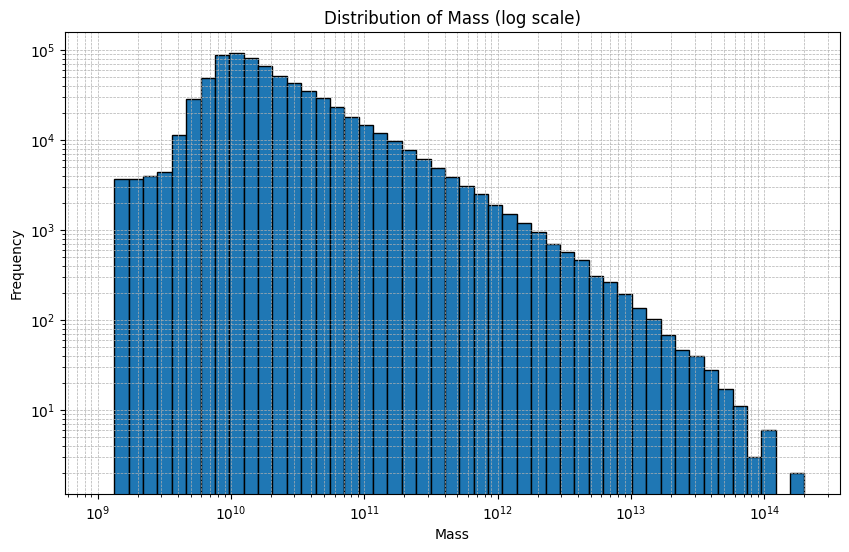

In [5]:
# Apply the lower limit
# mass_filtered = mass[mass >= 10**12]

# Create the histogram with a logarithmic scale
plt.figure(figsize=(10, 6))
# plt.hist(mass_filtered, bins=np.logspace(np.log10(min(mass)), np.log10(max(mass)), 50), edgecolor='black')  # Adjust bins as needed
plt.hist(mass, bins=np.logspace(np.log10(min(mass)), np.log10(max(mass)), 50), edgecolor='black')
plt.xscale('log')
plt.yscale('log')  # Use logarithmic scale for y-axis
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.title('Distribution of Mass (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


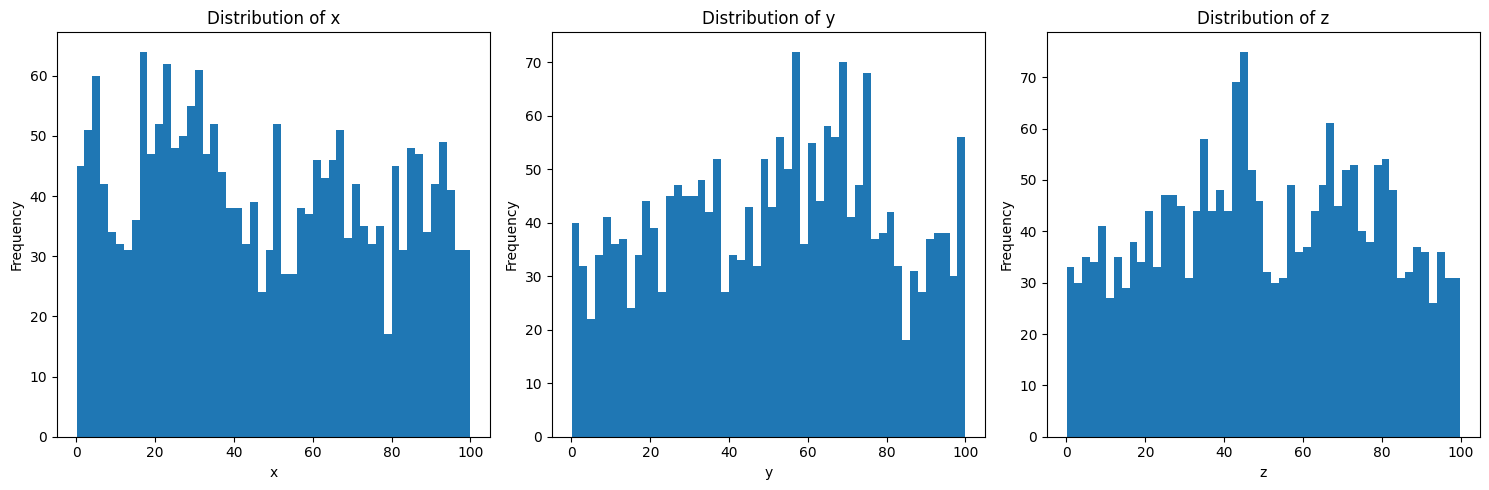

In [6]:
# Plotting the distrubution of x,y, z in the positions for those with mass more than 10^12

# Filter positions based on mass
mass_cut = 10**12.5
filtered_positions = position[mass >= mass_cut]

# Extract x, y, and z coordinates
x = filtered_positions[:, 0]
y = filtered_positions[:, 1]
z = filtered_positions[:, 2]

# Create histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(x, bins=50)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of x')

plt.subplot(1, 3, 2)
plt.hist(y, bins=50)
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of y')

plt.subplot(1, 3, 3)
plt.hist(z, bins=50)
plt.xlabel('z')
plt.ylabel('Frequency')
plt.title('Distribution of z')

plt.tight_layout()
plt.show()

(2075,) (2075,) (2075,)


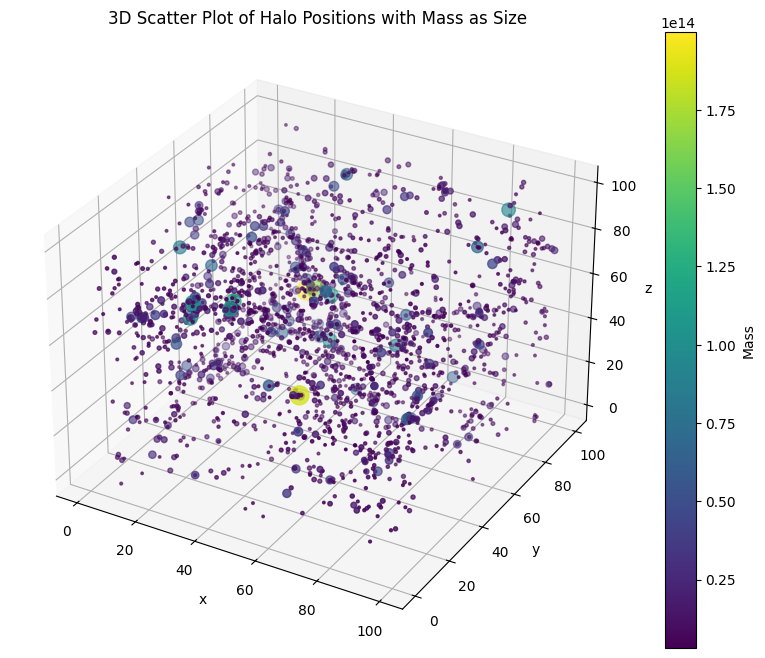

In [7]:
# A 3d plot with x,y,z of halos and mass on the colorbar

from mpl_toolkits.mplot3d import Axes3D

# Filter positions and masses based on the mass condition
filtered_positions = position[mass >= mass_cut]
filtered_masses = mass[mass >= mass_cut]

# Extract x, y, and z coordinates
x = filtered_positions[:, 0]
y = filtered_positions[:, 1]
z = filtered_positions[:, 2]
print(x.shape, y.shape, z.shape)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with size proportional to mass
scatter = ax.scatter(x, y, z, s=filtered_masses / 1e12, c=filtered_masses, cmap='viridis') # Adjust scaling as needed

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Scatter Plot of Halo Positions with Mass as Size')

# Add a colorbar to indicate mass
fig.colorbar(scatter, label='Mass')

# Show the plot
plt.show()


## Step 4: Build the Graph

We will build a simple spatial proximity graph using nearest neighbors.

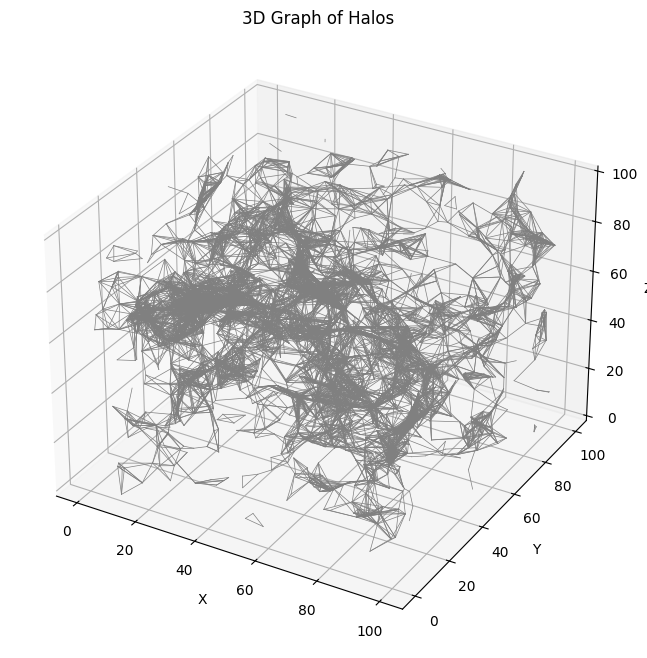

Number of graphs: 30


In [8]:
import networkx as nx

filtered_positions = position[mass >= mass_cut]
filtered_masses = mass[mass >= mass_cut]

# Calculate distance matrix
distance_matrix = np.linalg.norm(filtered_positions[:, np.newaxis, :] - filtered_positions[np.newaxis, :, :], axis=2)

# Create graph
graph = nx.Graph()
num_nodes = len(filtered_positions)

for i in range(num_nodes):
    graph.add_node(i, pos=filtered_positions[i], mass=filtered_masses[i])

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Avoid duplicate edges
        if distance_matrix[i, j] < 10:  # Edge if distance < 10
            graph.add_edge(i, j)

# Plot the graph (3D)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get node positions from the graph
node_positions = nx.get_node_attributes(graph, 'pos')

# Draw nodes
# nx.draw_networkx_nodes(graph, node_positions, node_size=10, ax=ax)  # Reduced node size for better visualization


# Draw edges (iterate through edges and plot as lines)
for u, v in graph.edges():
    pos_u = node_positions[u]
    pos_v = node_positions[v]
    ax.plot([pos_u[0], pos_v[0]], [pos_u[1], pos_v[1]], [pos_u[2], pos_v[2]], color='gray', linewidth=0.5) # Plot each edge as a line

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Graph of Halos')

plt.show()

# Number of connected components (graphs)
num_graphs = nx.number_connected_components(graph)
print(f"Number of graphs: {num_graphs}")


Number of nodes: 2075


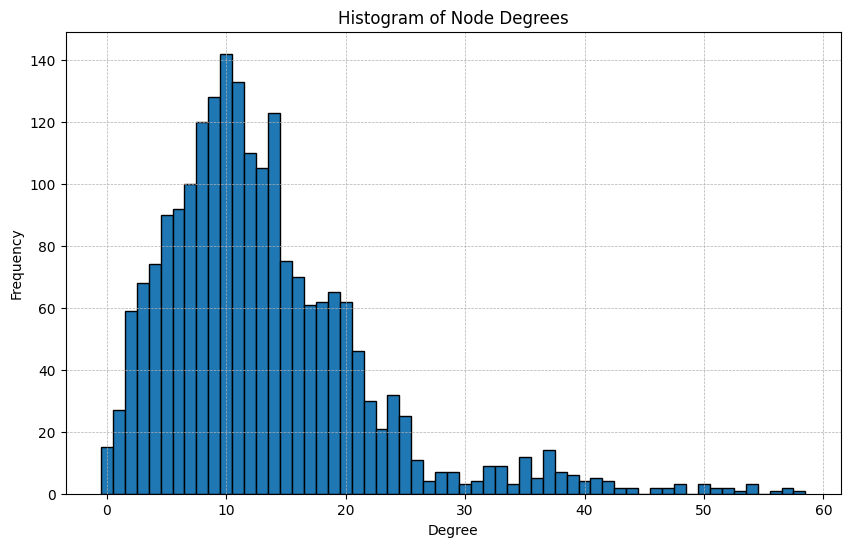

In [9]:
num_nodes = graph.number_of_nodes()
print(f"Number of nodes: {num_nodes}")

degree_sequence = [graph.degree(node) for node in graph.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degree_sequence, bins=range(max(degree_sequence) + 2), align='left', edgecolor='black') #histogram
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Histogram of Node Degrees")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


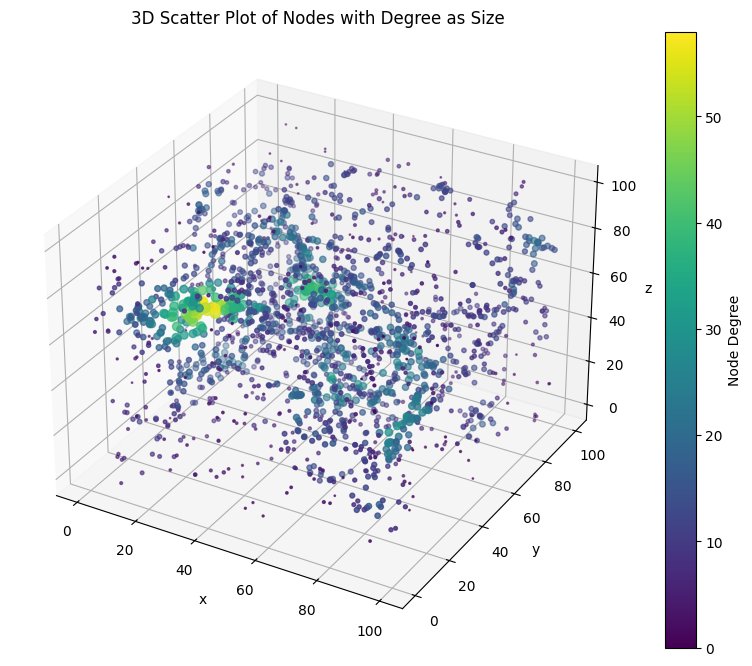

In [10]:
degree_centrality = nx.degree_centrality(graph)
node_degrees = list(dict(graph.degree()).values())

# Count nodes with degree > 20
degree_critria = 20
nodes_above = sum(1 for degree in node_degrees if degree > degree_critria)
#print(f"Number of nodes with degree greater than 20: {nodes_above}")


# 3D scatter plot with node degree as size
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get node positions from the graph
node_positions = nx.get_node_attributes(graph, 'pos')
node_x = [pos[0] for pos in node_positions.values()]
node_y = [pos[1] for pos in node_positions.values()]
node_z = [pos[2] for pos in node_positions.values()]


scatter = ax.scatter(node_x, node_y, node_z, s=node_degrees, c=node_degrees, cmap='viridis')  # Use node degree for size and color


# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Scatter Plot of Nodes with Degree as Size')

# Add a colorbar to indicate degree
fig.colorbar(scatter, label='Node Degree')

# Show the plot
plt.show()


## Step 5: Preparing the data


In [11]:
# Create node features (labels) based on degree
node_labels = []
for node in graph.nodes():
    degree = graph.degree(node)
    if degree > degree_critria:
        node_labels.append(0)  # Cluster node
    else:
        node_labels.append(1)  # Void node

node_labels = np.array(node_labels)

# Now you have node features (labels) in the 'node_labels' array. You can use this in the next steps for your GNN.

# Example: Convert to PyTorch Geometric Data object
edge_index = torch.tensor(list(graph.edges)).t().contiguous()
x = torch.tensor(node_labels, dtype=torch.long) # Node features are the labels
data = Data(x=x, edge_index=edge_index)

data


Data(x=[2075], edge_index=[2, 13636])

## Step 6: Define the GNN Model


In [15]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


## Step 7: Train the Model


In [16]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Generate train and test masks
num_nodes = data.x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assuming a 80/20 split for train/test
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_mask[train_idx] = True
test_mask[test_idx] = True
data.train_mask = train_mask
data.test_mask = test_mask
data.y = torch.tensor(node_labels, dtype=torch.long) #Assuming node_labels are your ground truth labels

# Initialize the model
model = GNN(num_node_features=1, hidden_channels=64, num_classes=2)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    # Reshape data.x to have 2 dimensions
    out = model(data.x.unsqueeze(1).float(), data.edge_index) # Reshape data.x to have 2 dimensions
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Print training loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    pred = model(data.x.unsqueeze(1).float(), data.edge_index).argmax(dim=1) # Reshape data.x to have 2 dimensions during evaluation as well
    acc = accuracy_score(node_labels, pred)
    print(f"Accuracy: {acc:.4f}")

Epoch 10/100, Loss: 0.3410
Epoch 20/100, Loss: 0.3422
Epoch 30/100, Loss: 0.3179
Epoch 40/100, Loss: 0.3072
Epoch 50/100, Loss: 0.2963
Epoch 60/100, Loss: 0.2952
Epoch 70/100, Loss: 0.2942
Epoch 80/100, Loss: 0.2888
Epoch 90/100, Loss: 0.2843
Epoch 100/100, Loss: 0.2811
Accuracy: 0.8998


## Step 8: Evaluate the Model
Let's Calculate the accuracy, precision, Recall, f1_score

Precision: 0.8956
Recall: 0.8998
F1-score: 0.8813
              precision    recall  f1-score   support

           0       0.85      0.35      0.50       294
           1       0.90      0.99      0.94      1781

    accuracy                           0.90      2075
   macro avg       0.88      0.67      0.72      2075
weighted avg       0.90      0.90      0.88      2075



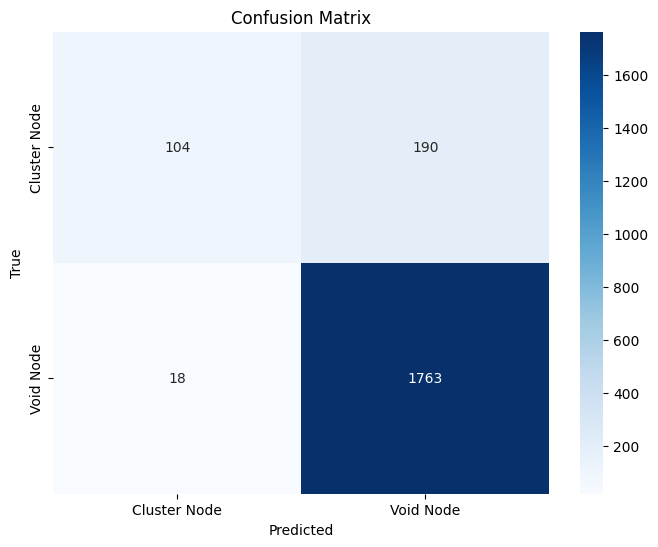

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
model.eval()
with torch.no_grad():
    pred = model(data.x.unsqueeze(1).float(), data.edge_index).argmax(dim=1)

    # Calculate precision, recall, and F1-score
    precision = precision_score(node_labels, pred, average='weighted')
    recall = recall_score(node_labels, pred, average='weighted')
    f1 = f1_score(node_labels, pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Print the classification report
    print(classification_report(node_labels, pred))

    # Compute and plot the confusion matrix
    conf_matrix = confusion_matrix(node_labels, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Cluster Node", "Void Node"],
                yticklabels=["Cluster Node", "Void Node"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Conclusion

You have:
- Loaded Rockstar halo data from CAMELS
- Built a graph of halo interactions
- Trained a simple GNN to classify halos by mass
- Evaluated and visualized your results

Next steps (optional for student):
- Improve graph construction (physical cuts, dynamic radius)
- Experiment with different GNN layers (GraphSAGE, GAT)
- Try regression instead of classification (predict mass)